In [74]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers

In [91]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [114]:
# TODO
# - split data into 13 training sets
# - try VAE
#   - change up
#   - explain with comments
#   - KL annealing?
# - try GAN
# - try DIFF

In [8]:
train_path = 'data/Ferguson_fire_train.npy'
val_path = 'data/Ferguson_fire_test.npy'
test_path = 'data/Ferguson_fire_obs.npy'

In [137]:
#load data - no standardisation required

train_data = np.array(np.load(open(train_path,'rb')))
train_data_1D = np.reshape(train_data, (np.shape(train_data)[0],np.shape(train_data)[1]*np.shape(train_data)[2]))
train_data_1D_shifted = train_data_1D[1:]

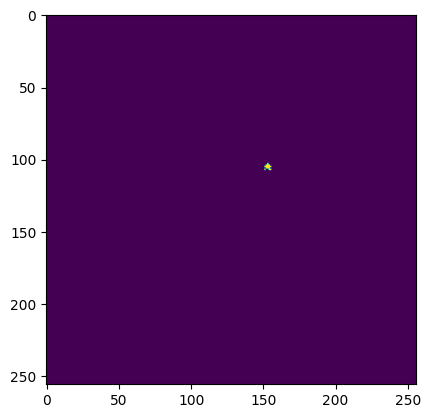

In [192]:
plt.imshow(train_data[])

In [213]:
def split_by_fire(arr, chunk_size):
    L = len(arr)
    num_chunks = L // chunk_size
    remainder = L % chunk_size
    chunks = np.split(arr[:L-remainder], num_chunks)
    if remainder != 0:
        chunks.append(arr[L-remainder:])
    return chunks

def create_x_y(data, chunk_size = 500):
    x = split_by_fire(data, chunk_size)
    y = split_by_fire(data, chunk_size)
    for i in range(len(x)):
        x[i] = x[i][:-1]
        y[i] = y[i][1:]
    return np.concatenate(x),np.concatenate(y) #test this



In [214]:
train_data = np.array(np.load(open(train_path,'rb')))
train_data_1D = np.reshape(train_data, (np.shape(train_data)[0],np.shape(train_data)[1]*np.shape(train_data)[2]))
train_data_x, train_data_y = create_x_y(train_data_1D)

val_data = np.array(np.load(open(val_path,'rb')))
val_data_1D = np.reshape(val_data, (np.shape(val_data)[0],np.shape(val_data)[1]*np.shape(val_data)[2]))
val_data_x, val_data_y = create_x_y(val_data_1D)

test_data = np.array(np.load(open(test_path,'rb')))
test_data_1D = np.reshape(test_data, (np.shape(test_data)[0],np.shape(test_data)[1]*np.shape(test_data)[2]))
test_data_1D_shifted = test_data_1D[1:]
test_data_1D = test_data_1D[:-1]

In [ ]:
# try some fancy data aug stuff here?

# train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [198]:
BATCH_SIZE = 128
LATENT_DIM = 2
LEARNING_RATE = 0.001
EPOCHS = 100
INPUT_SHAPE = 65536

In [215]:
#explain everything with comments

def sampling(args, latent_dim=LATENT_DIM):
    mean, log_var = args
    eps = tf.random.normal(shape=(tf.shape(mean)[0], latent_dim), mean=0., stddev=1.0)
    return mean + tf.exp(log_var/2.) * eps

def make_encoder(input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM, condition_size=CONDITION_SIZE, batch_size=BATCH_SIZE):
    x = layers.Input(shape=(input_shape,))
    h = layers.Dense(units=512,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(x)
    h = layers.Dense(units=256,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(h)
    h = layers.Dense(units=128,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(h)
    h = layers.Dense(units=64,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(h)
    mean = layers.Dense(units=latent_dim)(h)
    log_var = layers.Dense(units=latent_dim)(h)
    return tf.keras.Model(inputs=[x],outputs=[mean,log_var], name='encoder')

def make_decoder(output_shape=INPUT_SHAPE, batch_size=BATCH_SIZE, latent_dim=LATENT_DIM, condition_size=CONDITION_SIZE):
    z = layers.Input(shape=(latent_dim,))
    h = layers.Dense(units=64,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(z)
    h = layers.Dense(units=128,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(h)
    h1 = layers.Dense(units=256,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(h) # prevent vanishing grads
    h2 = layers.Dense(units=512,activation='relu',activity_regularizer=tf.keras.regularizers.l1(1e-5))(h1) 
    y = layers.Dense(units=output_shape,activation='sigmoid')(h2)
    return tf.keras.Model(inputs=[z],outputs=y, name='decoder')

#change this MASSIVELY 
def loss(x, y, mean, log_var, alpha=1.0, beta=1.0):
    r_loss = tf.keras.losses.mean_squared_error(y_true=x, y_pred=y)
    r_loss = tf.reduce_mean(r_loss, name='recon_loss')
    kl_loss = -0.5 * tf.reduce_mean(log_var - tf.square(mean) - tf.exp(log_var) + 1)
    kl_loss = tf.identity(kl_loss, name="kl_loss")
#     cvae_loss = alpha*r_loss + beta*kl_loss
    cvae_loss = alpha*r_loss + 0.0001*kl_loss
    return cvae_loss

In [216]:
encoder = make_encoder()
decoder = make_decoder()


x = layers.Input(shape=(INPUT_SHAPE,))
mean, log_var = encoder([x])
z = layers.Lambda(sampling)([mean, log_var])
y = decoder([z])

cvae = tf.keras.Model(inputs=[x], outputs=y, name='cvae')
cvae.add_loss(loss(x,y,mean,log_var,alpha=10))
cvae.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

In [217]:
if not os.path.exists('models'):
    os.makedirs('models')
chkpt_filepath = 'models/best'

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3), # monitors val_loss to prevent overfitting
    # save best model weights to allow reloading if training stopped early
    tf.keras.callbacks.ModelCheckpoint(filepath=chkpt_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
]
    
history = cvae.fit(train_data_x, train_data_y, epochs=100, batch_size=128, validation_data=(val_data_x,val_data_y), shuffle=True, callbacks=[my_callbacks])
cvae.load_weights(chkpt_filepath) # reloads best model weights
print("Training stopped")

Epoch 1/100
98/98 [==============================] - 47s 480ms/step - loss: 252.5925 - val_loss: 0.2182
Epoch 2/100
98/98 [==============================] - 46s 467ms/step - loss: 0.1831 - val_loss: 0.1613
Epoch 3/100
98/98 [==============================] - 46s 469ms/step - loss: 0.1594 - val_loss: 0.1519
Epoch 4/100
98/98 [==============================] - 47s 476ms/step - loss: 0.1505 - val_loss: 0.1405
Epoch 5/100
98/98 [==============================] - 47s 482ms/step - loss: 0.1328 - val_loss: 0.1178
Epoch 6/100
98/98 [==============================] - 50s 510ms/step - loss: 0.1148 - val_loss: 0.1062
Epoch 7/100
98/98 [==============================] - 48s 491ms/step - loss: 0.1058 - val_loss: 0.0985
Epoch 8/100
98/98 [==============================] - 48s 491ms/step - loss: 0.0939 - val_loss: 0.0947
Epoch 9/100
98/98 [==============================] - 48s 492ms/step - loss: 0.0896 - val_loss: 0.0906
Epoch 10/100
98/98 [==============================] - 48s 493ms/step - loss: 0.0

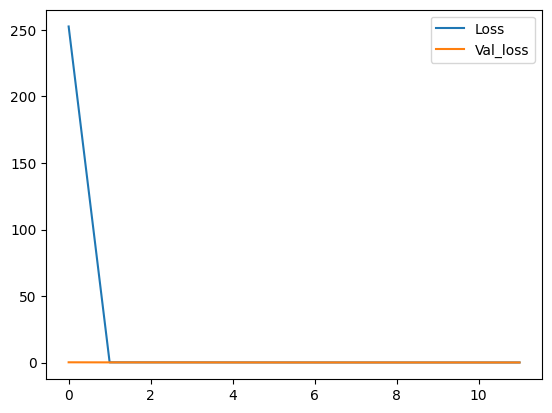

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss'])

In [225]:
from sklearn.metrics import mean_squared_error

# test model

test_data_gen = cvae.predict(test_data_1D)

mse = mean_squared_error(test_data_gen, test_data_1D_shifted)
print(f'MSE: {mse}')

1/1 [==============================] - 0s 34ms/step
MSE: 0.06925555100054566


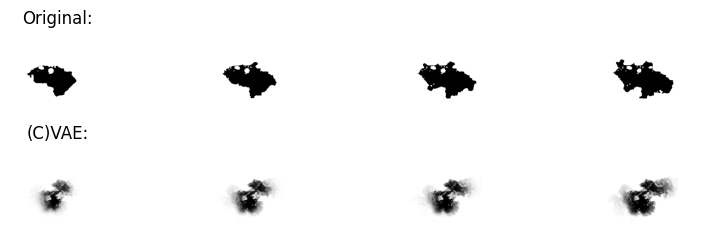

In [226]:
# plot original test data against generated test data

from random import randrange

plt.figure(figsize=(10, 6))

for i in range(1, 5):
    plt.subplot(2, 4, i)
    if i == 1:
        plt.title('Original:', loc='center')
    plt.imshow(test_data_1D_shifted[i-1,:].reshape(np.shape(test_data)[1],np.shape(test_data)[2]),cmap='gray_r')
    plt.axis('off') 
    
    plt.subplot(2, 4, i + 4)
    if i == 1:
        plt.title('(C)VAE:', loc='center')
    plt.imshow(test_data_gen[i-1,:].reshape(np.shape(test_data)[1],np.shape(test_data)[2]),cmap='gray_r')
    plt.axis('off')

plt.subplots_adjust(top=0.85, bottom=0.5, wspace=0.05)
plt.show()